In [74]:
  !pip install datasets
  !pip install transformers

# Classificazione su GoEmotion
---
## Dataset:
 GoEmotions è un corpus di commenti estratti da Reddit, con annotazioni umane a 27 categorie di emozioni o neutrali.

---
<table class="unstyledTable">
<thead>
<tr>
<th>No. etichette</th>
<th>Dimensione dataset di addestramento</th>
<th>Dimensione dataset di valutazione</th>
<th>Lunghezza massima sequenze nei dataset</th>
</tr>
</thead>
<tbody>
<tr>
<td>27</td>
<td>43,410     -[PULIZIA]->      36,146</td>
<td>5,427</td>
<td>30</td>
</tr>
</tbody>
</table>

---
<p>
Per comprendere ulteriormente la suddivisione di queste 27 etichette ho raggruppato in una tabella ognuna delle etichette secondo il mapping di ekman fatto dal gruppo di ricerca di Google
</p>
<details> <br/>

[ekman_mapping](https://github.com/google-research/google-research/blob/master/goemotions/data/ekman_mapping.json)
<br/>

<table class="unstyledTable">
<thead>
<tr>
<th>Rabbia</th>
<th>Disgusto</th>
<th>Paura</th>
<th>Felicità</th>
<th>Tristezza</th>
<th>Sorpresa</th>
</tr>
</thead>
<tfoot>
<tr>
<td>3</td>
<td>1</td>
<td>2</td>
<td>11</td>
<td>2</td>
<td>2</td>
</tr>
</tfoot>
<tbody>
<tr>
<td>rabbia</td><td>disgusto</td><td>paura</td><td>gioia</td><td>tristezza</td><td>sorpresa</td></tr>
<tr>
<td>fastidio</td><td></td><td>nervosismo</td><td>divertimento</td><td>delusione</td><td>realizzazione</td></tr>
<tr>
<td>dissenso</td><td></td><td></td><td>approvazione</td><td></td><td></td></tr>
<tr>
<td></td><td></td><td></td><td>entusiasmo</td><td></td><td></td></tr>
<tr>
<td> </td><td> </td><td> </td><td>gratitudine</td><td></td><td></td></tr>
<tr>
<td></td><td></td><td> </td><td>amore</td><td></td><td></td></tr>
<tr>
<td></td><td></td><td> </td><td>ottimismo</td><td></td><td></td></tr>
<tr>
<td></td><td></td><td></td><td>sollievo</td><td></td><td></td></tr>
<tr>
<td></td><td></td><td></td><td>orgoglio</td><td></td><td></td></tr>
<tr>
<td></td><td></td><td></td><td>ammirazione</td><td></td><td></td></tr>
<tr>
<td></td><td></td><td></td><td>desiderio</td><td></td><td></td></tr>
<tr>
<td></td><td></td><td></td><td>cura/supporto</td><td></td><td></td></tr>

</tbody>
</tr>
</table>
</details> <br/>


# FASE 1: i dati
---

### **Caricamento e preparazione dei dati**:
1. carica il dataset GoEmotion
2. effettua una pulizia dei dati rimuovendo duplicati e testi nulli
3. mappa le etichette in emozioni specifiche.
4. visualizzazione della distribuzione delle etichette delle emozioni nel dataset prima e dopo la pulizia dei dati.
5. divisione train/set


### Step 1: Installazione e caricamento dei dati  
In questa fase, installiamo le librerie necessarie e carichiamo il dataset “go_emotions”. Questo dataset viene poi convertito in un dataframe di pandas per una manipolazione più facile.

In [75]:
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from datasets import load_dataset

#---Carico il dataset di GoEmotion
dataset = load_dataset("go_emotions")
#Inizializzo un dataframe in pandas come df_emotion
df_emotion = pd.DataFrame(dataset['train'])


In [76]:
df_emotion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    43410 non-null  object
 1   labels  43410 non-null  object
 2   id      43410 non-null  object
dtypes: object(3)
memory usage: 1017.5+ KB


### Step 2: Analisi esplorativa dei dati
Qui, calcoliamo la distribuzione delle etichette di sentimento nel nostro dataset e creiamo un grafico a barre per visualizzare questa distribuzione. Questo ci aiuta a capire come sono distribuiti i sentimenti nel nostro dataset

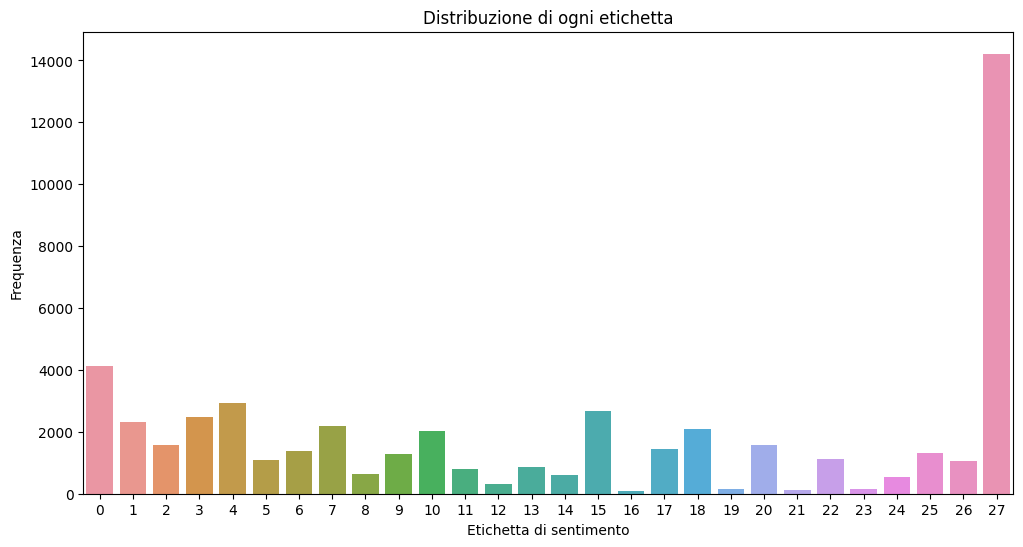

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la distribuzione delle etichette di sentimento
distribuzione_etichette = df_emotion['labels'].explode().value_counts()

# Crea un grafico a barre
plt.figure(figsize=(12, 6))
sns.barplot(x=distribuzione_etichette.index, y=distribuzione_etichette.values)

# Aggiungi etichette agli assi
plt.xlabel("Etichetta di sentimento")
plt.ylabel("Frequenza")
plt.title("Distribuzione di ogni etichetta")
# Mostra il grafico
plt.show()


### Step 3: Pulizia dei dati
In questa fase, puliamo i nostri dati eliminando i duplicati e organizzando i dati aggregando le diverse etichette. Eliminiamo anche i testi con più etichette al suo interno e gestiamo eventuali valori mancanti nel set di dati.

In [78]:

#--pulisco i dati--
#Elimino i possibili duplicati confrontando i testi
df_emotion.drop_duplicates(subset=['text'], inplace=True)

# Organizzo i dati aggregando le diverse etichette/labels
df_emotion.sort_values(by=['labels'], inplace=True)

# Elimino i testi con più etichette al suo interno
df_emotion = df_emotion[df_emotion['labels'].apply(lambda x: len(x) == 1)]

#Verificare e gestire eventuali valori mancanti nel set di dati.
df_emotion.dropna(subset=['text'], inplace=True)


<ipython-input-78-c008581ec946>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emotion.dropna(subset=['text'], inplace=True)


### Step 4: Mappatura delle etichette
Creiamo un dizionario per mappare le etichette numeriche ai loro corrispondenti sentimenti. Questo ci aiuta a rendere i nostri dati più leggibili.<br/>
Nell'elenco è presenta la traduzione delle 27 emozioni + 1 neutra
<details>

[google-research/goemotions/data/emotions.txt](https://github.com/google-research/google-research/blob/master/goemotions/data/emotions.txt)
</details>

In [79]:
# Creo un dizionario per il mapping
emotion_diz = {0:'admiration',
    1: 'amusement',
    2: 'anger',
    3: 'annoyance',
    4: 'approval',
    5: 'attention',
    6: 'confusion',
    7: 'curiosity',
    8: 'desire',
    9: 'disappointment',
    10: 'disapproval',
    11: 'disgust',
    12: 'embarrassment',
    13: 'excitement',
    14: 'fear',
    15: 'gratitude',
    16: 'grief',
    17: 'joy',
    18: 'love',
    19: 'nervousness',
    20: 'optimism',
    21: 'pride',
    22: 'realization',
    23: 'relief',
    24: 'remorse',
    25: 'sadness',
    26: 'surprise',
    27: 'neutral'}

# estrarre il numero intero dall'elenco prima di sostituirlo con una stringa.
df_emotion['labels'] = df_emotion['labels'].apply(lambda x: emotion_diz[x[0]])

# infine cambio anche il nome di text e labels
df_emotion.rename(columns={'labels': 'Sentiment', 'text':'Testo'}, inplace=True)


### Step 5: Rappresentazione dei sentimenti sul dataset dopo la pulizia
Dopo aver pulito i nostri dati, calcoliamo di nuovo la distribuzione delle etichette di sentimento e creiamo un altro grafico a barre. <br/>Questo ci mostra come sono distribuiti i sentimenti nel nostro dataset dopo la pulizia

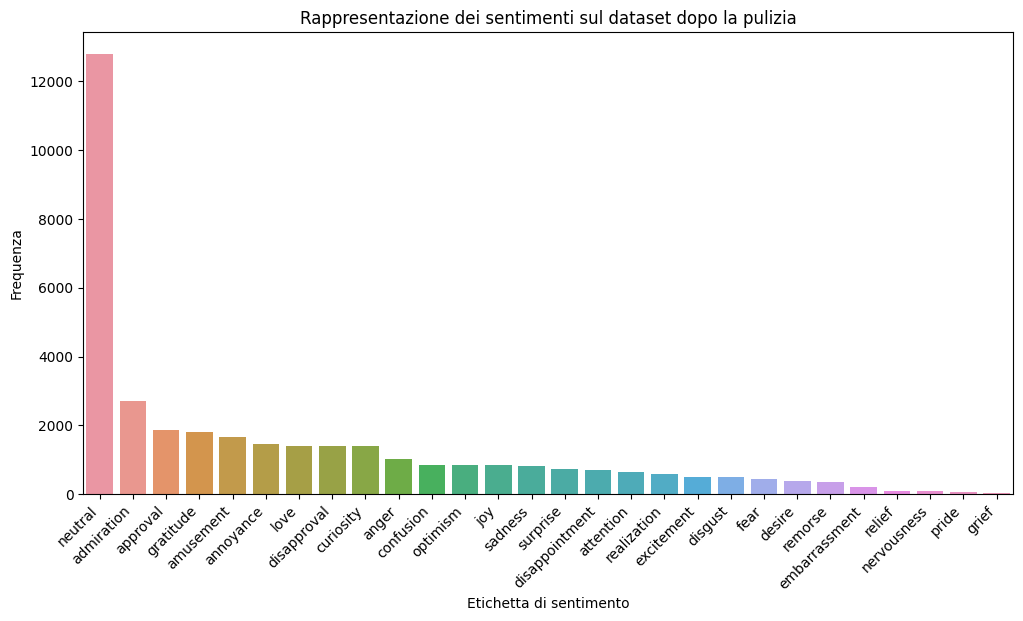

In [80]:

# Calcola la distribuzione delle etichette di sentimento
distribuzione_etichette_2 = df_emotion['Sentiment'].explode().value_counts()

# Crea un grafico a barre
plt.figure(figsize=(12, 6))
sns.barplot(x=distribuzione_etichette_2.index, y=distribuzione_etichette_2.values)

# Aggiungi etichette agli assi
plt.xlabel("Etichetta di sentimento")
plt.ylabel("Frequenza")
plt.title("Rappresentazione dei sentimenti sul dataset dopo la pulizia")
# Ruota le etichette sull'asse x per una migliore leggibilità
plt.xticks(rotation=45, ha='right')

# Mostra il grafico
plt.show()


In [81]:
distribuzione_etichette_2

neutral           12789
admiration         2698
approval           1870
gratitude          1815
amusement          1651
annoyance          1447
love               1409
disapproval        1401
curiosity          1385
anger              1022
confusion           857
optimism            856
joy                 847
sadness             813
surprise            716
disappointment      707
attention           644
realization         585
excitement          504
disgust             496
fear                428
desire              389
remorse             353
embarrassment       202
relief               88
nervousness          85
pride                50
grief                39
Name: Sentiment, dtype: int64

### Step 6: Divisione del dataset
Infine, dividiamo il nostro dataset in set di addestramento e di test. Questo ci permette di addestrare il nostro modello sui dati di addestramento e poi testarlo sui dati di test per vedere quanto è accurato.

<hr/>
Dimensioni dei datataframes dopo la divisione
<table class="unstyledTable">
<thead>
<tr>
<th>Totali</th>
<th>Train</th>
<th>Test</th>
</tr>
</thead>
<tfoot>
</tfoot>
<tbody>
<tr>
<td>36.146</td>
<td>28.916</td>
<td>7.230 </td>
</tr>
</tbody>
</table>

In [82]:
train_size = 0.8  # 80% train
test_size = 0.2 # 20% test

# divido il dataset in train all'80 e il restante 20% tra val e test
df_train, df_test = train_test_split(df_emotion, train_size=train_size, test_size=test_size, random_state=42, stratify=df_emotion['Sentiment'])

In [83]:
df_test

,Testo,Sentiment,id
7178,I just /facepalmed myself into oblivion.,neutral,ee48iu5
3969,You're thinking of the mirror universe from St...,neutral,ed343cu
6718,I’m so glad I have my own car,joy,ef81sax
28454,That was what our media guys said but he is no...,confusion,ee98f1s
32870,thor ulted minions reported for trolling,neutral,eeb3qd0
...,...,...,...
39773,His last post to T_D was to try and rile peopl...,annoyance,eeyhbn2
6445,This hit me a little too close to home,neutral,ef5cjgx
25257,"thanks! yeah a bit, wrote for my college paper...",gratitude,eddcqi2
28674,"creepy, the only way to make it more creepy is...",disgust,eeij4x1


# FASE 2: Generazione degli Embeddings

---
Step 1: Caricamento del `modello` e del `tokenizer` <br/>Il `modello BERT` viene utilizzato per `generare` gli `embeddings`, mentre il `tokenizer` `converte il testo` in ingresso in un formato comprensibile al modello.<br/>

Step 2: Definizione della `funzione` per generare gli `embeddings` <br/>Questa funzione prende in `input` una lista di `testi`, il `modello` e il `tokenizer`. <br/>La funzione genera gli `embeddings in batch` per ridurre il consumo di memoria. Gli embeddings vengono `calcolati prendendo la media` dell’ultimo stato nascosto `del tensore di output` lungo la dimensione 1 (colonne). Questi embeddings vengono `convertiti in array numpy` e restituiti dalla funzione.


In [84]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np

#step 1
checkpoint = "bhadresh-savani/distilbert-base-uncased-emotion" #BERT
model = AutoModel.from_pretrained(checkpoint)# Questo è il modello usato per generare gli embeddings.
tokenizer = AutoTokenizer.from_pretrained(checkpoint) #converte il testo in ingresso in un formato comprensibile al modello

#step2
def generate_embeddings(texts, model, tokenizer, batch_size=32):
    embeddings = [] #memorizza gli embeddings generate dal modello.
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad(): #Questo metodo  imposta eventuali "requires_grad" su False, riducendo il consumo di memoria per i calcoli.
            output = model(**inputs) #Gli input tokenizzati vengono quindi passati attraverso il modello per ottenere i tensori di output.
        embeddings.extend(output.last_hidden_state.mean(dim=1).numpy())
        '''
        calcolati prendendo la media dell'ultimo stato nascosto del tensore di output lungo la dimensione 1 (colonne).
        Questi embeddings vengono convertiti in array numpy
        '''
    return np.vstack(embeddings) ##la funzione restituisce un array numpy stackato verticalmente di tutti gli embeddings



 - train_embeddings e test_embeddings sono calcolati utilizzando il modello di embedding distilbert-base-uncased-emotion con il dataset GoEmotion (df_train['Testo'] e df_test['Testo']).

 - Questi vettori di embedding sono basati sul modello specifico distilbert-base-uncased-emotion


Step 3: Generazione degli `embeddings per l’insieme di addestramento`<br/>
In questa fase, generiamo gli embeddings per l’insieme di addestramento. Convertiamo la colonna Testo del dataframe di addestramento(train) in una lista e passiamo questa lista alla nostra funzione per generare gli embeddings.

In [85]:
# Generare le incorporazioni per gli insiemi di addestramento e di train
train_texts = df_train['Testo'].tolist()  #converto da pandas ad una lista python
train_embeddings = generate_embeddings(train_texts, model, tokenizer)

Step 4: Generazione degli `embeddings per l’insieme di test` <br/>
Convertiamo la colonna ‘Testo’ del dataframe di test in una lista e passiamo questa lista alla nostra funzione per generare gli embeddings.

In [86]:
# Generare le incorporazioni per gli insiemi di addestramento e di test
test_texts = df_test['Testo'].tolist()
test_embeddings = generate_embeddings(test_texts, model, tokenizer)

### Check Embeddings
  1. Definizione della funzione di similarità del coseno <br/>
La funzione (`check_cosine_similarity`) prende `due frasi come input`, le `converte in tensori` utilizzando il tokenizer e poi `genera` gli `embeddings per ciascuna frase` utilizzando il modello. <br/>Questi embeddings vengono `poi confrontati utilizzando la similarità del coseno`.

2. `Calcolo della similarità` del coseno tra le frasi <br/> la funzione calcola la similarità tra diverse coppie di frasi. <br/>Queste coppie di frasi sono scelte in modo da illustrare come gli embeddings possano catturare sia la somiglianza delle parole che il contesto in cui vengono utilizzate.

<hr/>


In [100]:
from sklearn.metrics.pairwise import cosine_similarity
# Calcolo la consine similarity tra due frasi di esempio
def check_cosine_similarity(testo1, testo2, model, tokenizer):
    frase1 = tokenizer(testo1, return_tensors="pt", max_length=128, padding=True, truncation=True) #restituisce le frasi come tensori pytorch
    frase2 = tokenizer(testo2, return_tensors="pt", max_length=128, padding=True, truncation=True)# max_length, truncation e padding servono ad omologare i dati

    with torch.no_grad():
        embeddings1 = model(**frase1).last_hidden_state.mean(dim=1) # l_h-s -> contiene gli embedding delle frasi a livello di parola
        embeddings2 = model(**frase2).last_hidden_state.mean(dim=1)

    similarity = cosine_similarity(embeddings1, embeddings2)
    return similarity[0][0]
# Frasi di esempio da confrontare
testo1 = "I like to play soccer with my friends. "
testo2 = "My favorite activity is football with my buddies."

testo3 = "He saw a bat flying in the night sky."
testo4 = "He hit a home run with his bat."

testo5 = "I’m so happy that you are here with me. "
testo6 = "I’m so angry that you are here with me."

# Calcola la somiglianza
similarity_score = check_cosine_similarity(testo1, testo2, model, tokenizer)
print(f"Esempio 1:\n Frasi con parole diverse ma con significati simili\nCosine Similarity: {similarity_score}\n")

similarity_score = check_cosine_similarity(testo3, testo4, model, tokenizer)
print(f"Esempio 2:\n Frasi che hanno parole simili ma significati diversi\nCosine Similarity: {similarity_score}\n")

similarity_score = check_cosine_similarity(testo5, testo6, model, tokenizer)
print(f"Esempio 3:\n Frasi con emozioni diverse (il più importante)\nCosine Similarity: {similarity_score}\n")


Esempio 1:
 Frasi con parole diverse ma con significati simili
Cosine Similarity: 0.8524816036224365

Esempio 2:
 Frasi che hanno parole simili ma significati diversi
Cosine Similarity: 0.6516185998916626

Esempio 3:
 Frasi con emozioni diverse (il più importante)
Cosine Similarity: 0.06139547377824783



<hr/>
3. Creazione dello scatter plot:<br/>

- Step 1: estraiamo le `etichette di sentimento` dal nostro dataframe di `addestramento` e le `coordinate x e y dai nostri embeddings` di addestramento. Questi dati saranno utilizzati per creare il nostro grafico.<br/>
- Step 2: creiamo uno `scatter plot per visualizzare gli embeddings di addestramento`. Utilizziamo una mappa di colori per rappresentare le diverse etichette di sentimento. `Ogni punto` nel grafico rappresenta `un embedding`, e `il colore` del punto indica `l’etichetta di sentimento` corrispondente<br/>
- Step 3: visualizziamo il grafico. Questo ci permette di `vedere come sono distribuiti gli embeddings` nel nostro spazio bidimensionale `e come le diverse etichette` di sentimento `sono raggruppate`.

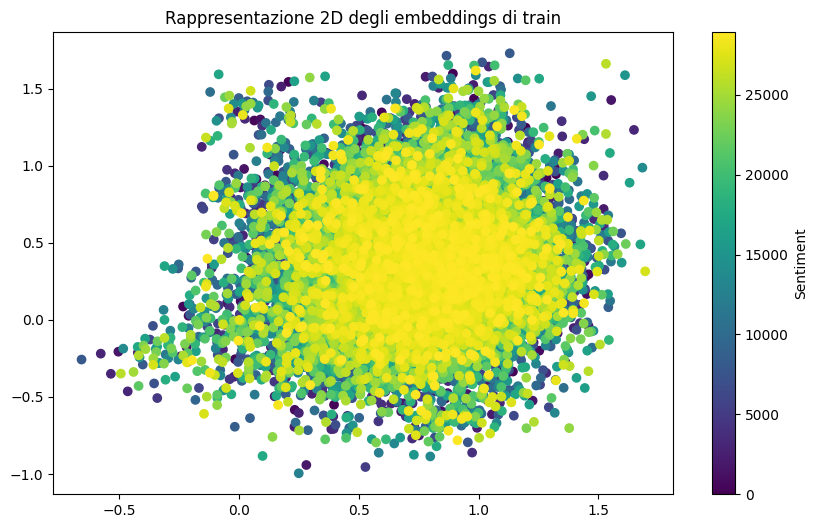

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Esempio di mappa di colori (colormap) per le etichette
colormap = plt.get_cmap('viridis')

# Estrai le etichette di sentimento
etichette_sentimento = df_train['Sentiment']
# Estrai le coordinate x e y dagli embeddings di addestramento
x_train = train_embeddings[:, 0]
y_train = train_embeddings[:, 1]
# Crea uno scatter plot per visualizzare gli embeddings di addestramento
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_train, y_train, c=np.arange(len(etichette_sentimento)), cmap=colormap)
plt.colorbar(scatter, label='Sentiment')
plt.title('Rappresentazione 2D degli embeddings di train')
plt.show()


# FASE 3: Classificazione




### 1. Classificazione unsupervised(argmax):
<hr/>

- Step 1: codifichiamo le etichette di sentimento in numeri interi utilizzando un `LabelEncoder`. Questo ci permette di lavorare con le `etichette in` un `formato` che i nostri `modelli` possono comprendere.
- Step 2: Calcoliamo la `similarità del coseno tra gli embeddings` del `test` e quelli del `train`. Questo ci dà una misura di quanto ogni frase del test sia simile a ogni frase del train.
- Step 3: utilizziamo il `metodo argmax per classificare` le frasi. Per ogni `frase del test`, scegliamo `l’etichetta della frase del train che ha la massima similarità` del coseno.
- Step 4: `matrice di confusione` per argmax Qui, calcoliamo la matrice di confusione per le etichette predette con argmax e la `visualizziamo` come un `heatmap`. Questo ci permette di `vedere quanto spesso il nostro classificatore argmax ha predetto correttamente` l’etichetta di sentimento.


In [101]:
from sklearn.preprocessing import LabelEncoder

# Codifico le etichette
le = LabelEncoder()
train_labels = le.fit_transform(df_train['Sentiment']) #trasforma le etichette in numeri interi. Ogni etichetta unica viene mappata su un numero intero unico
test_labels = le.transform(df_test['Sentiment']) #usando l’encoder addestrato (no fit) perché vogliamo usare la mappatura appresa dal set di addestramento

matrice_similarity = cosine_similarity(test_embeddings, train_embeddings)

# One Nearest Neighbour
predicted_indices = np.argmax(matrice_similarity, axis=1) #Qui stiamo ottenendo l’indice del valore massimo per ogni riga
predicted_labels = train_labels[predicted_indices] # Infine, stiamo mappando gli indici predetti alle loro rispettive etichette nel set di addestramento. Queste diventano le nostre etichette predette per il set di test


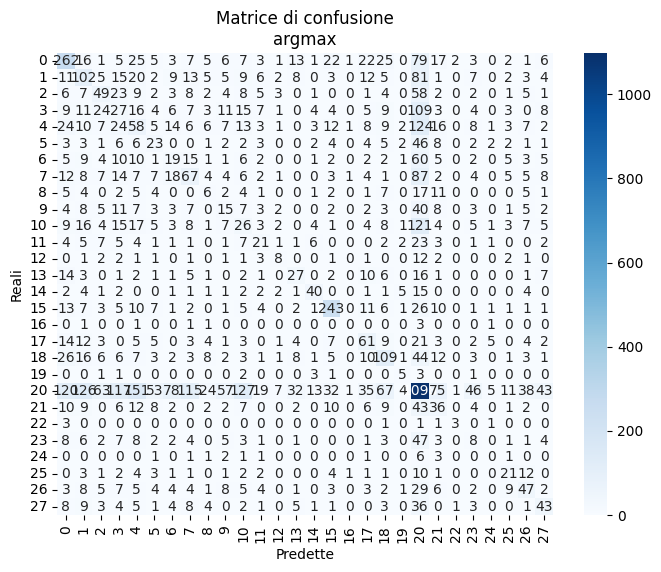

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di confusione
cm = confusion_matrix(test_labels, predicted_labels)

# Disegna la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predette')
plt.ylabel('Reali')
plt.title('Matrice di confusione\nargmax')
plt.show()

In [93]:
emotion_diz

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'attention',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral'}

quante volte il valore reale viene predetto con le altre etichette (quante volte vengono confuse)

### 2. classificazione supervisionata con logistic regression.
<hr/>

- Step 1: Addestriamo un `modello sugli embeddings del train e le etichette` corrispondenti. Poi usiamo questo modello per `predire le etichette delle frasi del test`.
- Step 2: Calcoliamo la `media delle somiglianze tra ogni frase del test e tutte le frasi del train`. Questo ci dà una misura di quanto in media ogni frase del test sia simile alle frasi del train.
- Step 3: Visualizzazione della `matrice di confusione` per la `logistic regression`. Calcoliamo la matrice di confusione per le etichette predette con la regressione logistica e la visualizziamo come un heatmap.  
Questo ci permette di vedere quanto sono vicine le frasi nello spazio vettoriale e se il modello riesce a catturare le sfumature dei sentimenti.

Il modello
  1. `predice il sentimento di ogni frase del test`
  2. `lo confronta con il sentimento reale`.
  3. `calcola la somiglianza tra` le frasi del `test` e le frasi del `training` usando il coseno tra i loro vettori di embedding.


In [89]:
from sklearn.linear_model import LogisticRegression
classif = LogisticRegression(random_state=42)
classif.fit(train_embeddings, df_train['Sentiment'])#Uso il metodo fit() per allenare il modello usando gli embedding delle frasi del train e le etichette dei sentimenti corrispondenti.
test_pred = classif.predict(test_embeddings) #predire i sentimenti delle frasi del test in una variabile chiamata test pred

df_test['similarity'] = np.mean(matrice_similarity, axis=1) #media delle somiglianze tra ogni frase del test e tutte le frasi del training

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


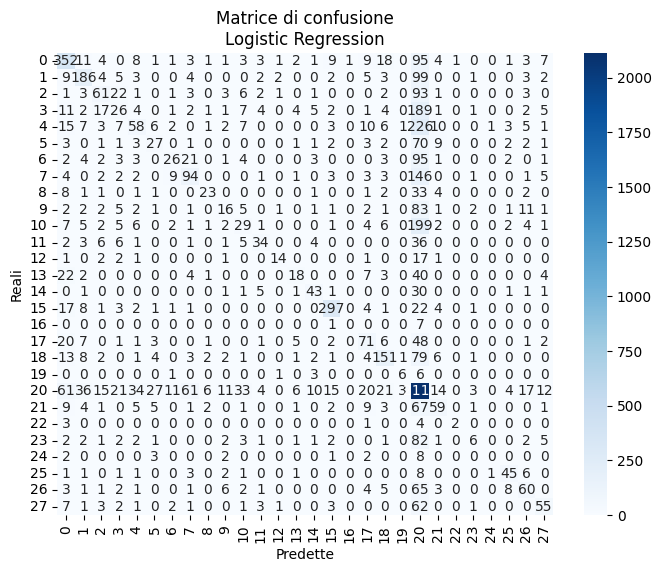

In [90]:
# Calcola la matrice di confusione
conf_matrix = confusion_matrix(df_test['Sentiment'], test_pred)

# Disegna la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predette')
plt.ylabel('Reali')
plt.title('Matrice di confusione\nLogistic Regression')
plt.show()


# FASE 4: Validazione con ScikitLearn's classification report

In [94]:
from sklearn.metrics import classification_report
# Calcola il report di classificazione per logistic regression
report_lr = classification_report(df_test['Sentiment'], test_pred, target_names=df_emotion['Sentiment'].unique(), output_dict=True) #output_dict=True per ottenere i report come dizionari.
print(f"Report Logistic Regression:\n {report_lr}")

df_lr = pd.DataFrame(report_lr).transpose()

Report Logistic Regression:
 {'admiration': {'precision': 0.610051993067591, 'recall': 0.6518518518518519, 'f1-score': 0.630259623992838, 'support': 540}, 'amusement': {'precision': 0.6305084745762712, 'recall': 0.5636363636363636, 'f1-score': 0.5952, 'support': 330}, 'anger': {'precision': 0.46564885496183206, 'recall': 0.29901960784313725, 'f1-score': 0.36417910447761187, 'support': 204}, 'annoyance': {'precision': 0.22413793103448276, 'recall': 0.0896551724137931, 'f1-score': 0.12807881773399013, 'support': 290}, 'approval': {'precision': 0.41134751773049644, 'recall': 0.15508021390374332, 'f1-score': 0.22524271844660193, 'support': 374}, 'attention': {'precision': 0.3375, 'recall': 0.20930232558139536, 'f1-score': 0.25837320574162675, 'support': 129}, 'confusion': {'precision': 0.45614035087719296, 'recall': 0.15204678362573099, 'f1-score': 0.22807017543859648, 'support': 171}, 'curiosity': {'precision': 0.4563106796116505, 'recall': 0.33935018050541516, 'f1-score': 0.3892339544513

In [95]:

# Calcola il report di classificazione per argmax
report_argmax = classification_report(test_labels, predicted_labels, target_names=le.classes_, output_dict=True)
print(f'Report argmax:\n{report_argmax}')

df_argmax = pd.DataFrame(report_argmax).transpose()

Report argmax:
{'admiration': {'precision': 0.45565217391304347, 'recall': 0.48518518518518516, 'f1-score': 0.46995515695067264, 'support': 540}, 'amusement': {'precision': 0.2524752475247525, 'recall': 0.3090909090909091, 'f1-score': 0.2779291553133515, 'support': 330}, 'anger': {'precision': 0.24019607843137256, 'recall': 0.24019607843137256, 'f1-score': 0.24019607843137256, 'support': 204}, 'annoyance': {'precision': 0.08517350157728706, 'recall': 0.09310344827586207, 'f1-score': 0.08896210873146625, 'support': 290}, 'approval': {'precision': 0.1468354430379747, 'recall': 0.15508021390374332, 'f1-score': 0.1508452535760728, 'support': 374}, 'attention': {'precision': 0.152317880794702, 'recall': 0.17829457364341086, 'f1-score': 0.1642857142857143, 'support': 129}, 'confusion': {'precision': 0.10857142857142857, 'recall': 0.1111111111111111, 'f1-score': 0.10982658959537572, 'support': 171}, 'curiosity': {'precision': 0.2326388888888889, 'recall': 0.24187725631768953, 'f1-score': 0.23

In [96]:
# Unisci i due dataframes
df_confronto = pd.concat([df_lr, df_argmax], axis=1, keys=['Logistic Regression', 'Argmax'])
# Salva il dataframe di confronto in un file CSV
df_confronto.to_csv('confronto_classificatori.csv')
print(df_confronto)


               Logistic Regression                                     Argmax  \
                         precision    recall  f1-score      support precision   
admiration                0.610052  0.651852  0.630260   540.000000  0.455652   
amusement                 0.630508  0.563636  0.595200   330.000000  0.252475   
anger                     0.465649  0.299020  0.364179   204.000000  0.240196   
annoyance                 0.224138  0.089655  0.128079   290.000000  0.085174   
approval                  0.411348  0.155080  0.225243   374.000000  0.146835   
attention                 0.337500  0.209302  0.258373   129.000000  0.152318   
confusion                 0.456140  0.152047  0.228070   171.000000  0.108571   
curiosity                 0.456311  0.339350  0.389234   277.000000  0.232639   
desire                    0.589744  0.294872  0.393162    78.000000  0.074074   
disappointment            0.296296  0.113475  0.164103   141.000000  0.102740   
disapproval               0.

In [97]:
from google.colab import drive
drive.mount('/content/gdrive')
df_finale = pd.read_csv('/content/gdrive/MyDrive/Scatola Nera Seminario/confronto_classificatori.csv - Tabella pivot 3.csv')

df_finale


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Sentiment_Labels,precision LR,precision ArgM,recall LR,recall ArgM,f1-score LR,f1-score ArgM,support LR,support ArgM
0,accuracy,0.535546,0.335270,0.535546,0.335270,0.535546,0.335270,0.535546,0.33527
1,admiration,0.610052,0.455652,0.651852,0.485185,0.630260,0.469955,540.000000,540.00000
2,amusement,0.630508,0.252475,0.563636,0.309091,0.595200,0.277929,330.000000,330.00000
3,anger,0.465649,0.240196,0.299020,0.240196,0.364179,0.240196,204.000000,204.00000
4,annoyance,0.224138,0.085174,0.089655,0.093103,0.128079,0.088962,290.000000,290.00000
5,approval,0.411348,0.146835,0.155080,0.155080,0.225243,0.150845,374.000000,374.00000
6,attention,0.337500,0.152318,0.209302,0.178295,0.258373,0.164286,129.000000,129.00000
7,confusion,0.456140,0.108571,0.152047,0.111111,0.228070,0.109827,171.000000,171.00000
8,curiosity,0.456311,0.232639,0.339350,0.241877,0.389234,0.237168,277.000000,277.00000
9,desire,0.589744,0.074074,0.294872,0.076923,0.393162,0.075472,78.000000,78.00000


# TESTING
---
Funzione predict_emotion che prende in input una frase e restituisce l'emozione prevista utilizzando il modello addestrato.

Test Logistic Regression

In [98]:
# definire una funzione che prende in input una frase e restituisce in output l'etichetta dell'emozione
def predict_emotion_logistic(sentence):
   # tokenizzare la frase
    inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt", max_length=128)
     # generare embedding per la frase
    with torch.no_grad():
        output = model(**inputs)
    embedding = output.last_hidden_state.mean(dim=1).numpy()
    # indovina l'etichetta
    label = classif.predict(embedding)
    # restituisce l'etichetta come stringa
    return label[0]


# richiamare la funzione con una frase a scelta e stampare il risultato
sentence1 = "Wikipedia is the best thing ever. Anyone in the world can write anything they want about any subject so you know you are getting the best possible information"
emotion = predict_emotion_logistic(sentence1)
print(f"La frase:\n '{sentence1}' \nHa come emozione principale: \n'{emotion}'.\n")

sentence2 = "I feel so bad about the exam, I could've done more"
emotion = predict_emotion_logistic(sentence2)
print(f"La frase:\n '{sentence2}' \nHa come emozione principale: \n'{emotion}'.\n")

sentence3 = "You clearly don’t know who you’re talking to, so let me clue you in. I am not in danger, Skyler."
emotion = predict_emotion_logistic(sentence3)
print(f"La frase:\n '{sentence3}' \nHa come emozione principale: \n'{emotion}'.\n")

La frase:
 'Wikipedia is the best thing ever. Anyone in the world can write anything they want about any subject so you know you are getting the best possible information' 
Ha come emozione principale: 
'admiration'.

La frase:
 'I feel so bad about the exam, I could've done more' 
Ha come emozione principale: 
'sadness'.

La frase:
 'You clearly don’t know who you’re talking to, so let me clue you in. I am not in danger, Skyler.' 
Ha come emozione principale: 
'attention'.



Test Argmax

In [99]:
# definire una funzione che prende in input una frase e restituisce in output l'etichetta dell'emozione
def predict_emotion_argmax(sentence):
    # tokenizzare la frase
    inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt", max_length=128)
    # generare embedding per la frase
    with torch.no_grad():
        output = model(**inputs)
    embedding = output.last_hidden_state.mean(dim=1).numpy()
    # calcolare la similarità del coseno tra l'embedding della frase e gli embeddings del train
    similarity = cosine_similarity(embedding, train_embeddings)
    # ottenere l'indice dell'embedding del train con la massima similarità
    index = np.argmax(similarity)
    # ottenere l'etichetta corrispondente a quell'indice
    label = df_train['Sentiment'].iloc[index]
    # restituire l'etichetta
    return label

# richiamare la funzione con una frase a scelta e stampare il risultato
sentence1 = "Wikipedia is the best thing ever. Anyone in the world can write anything they want about any subject so you know you are getting the best possible information"
emotion = predict_emotion_argmax(sentence1)
print(f"La frase:\n '{sentence1}' \nHa come emozione principale: \n'{emotion}'.\n")

sentence2 = "I feel so bad about the exam, I could've done more"
emotion = predict_emotion_argmax(sentence2)
print(f"La frase:\n '{sentence2}' \nHa come emozione principale: \n'{emotion}'.\n")

sentence3 = "You clearly don’t know who you’re talking to, so let me clue you in. I am not in danger, Skyler."
emotion = predict_emotion_argmax(sentence3)
print(f"La frase:\n '{sentence3}' \nHa come emozione principale: \n'{emotion}'.\n")


La frase:
 'Wikipedia is the best thing ever. Anyone in the world can write anything they want about any subject so you know you are getting the best possible information' 
Ha come emozione principale: 
'love'.

La frase:
 'I feel so bad about the exam, I could've done more' 
Ha come emozione principale: 
'remorse'.

La frase:
 'You clearly don’t know who you’re talking to, so let me clue you in. I am not in danger, Skyler.' 
Ha come emozione principale: 
'disappointment'.

